## **Setup**

##### install wandb

In [1]:
!pip install wandb   # run this command to insatll wandb on colab - worth it!

##### setup

In [2]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

import wandb
from wandb.keras import WandbCallback

from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from tensorflow.keras.applications import ResNet50, VGG19, InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inception_resnet_v2_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0'

In [3]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
# Set and test path to competition data files
competition_path = 'My Drive/Final Project ITC/MAFAT Challenge/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{mount_path}/{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


### model configurations - dict

In [37]:
model_input = {
                'data_extraction':  {
                                    'train_df': [2, False],  # [num segments in track, balance the data?]
                                    'valid_df': [2, True],
                                    'exp_df':   [1, False],
                                    'synth_df': [3, True]
                                    },
                'model_conf' : {
                              'batch_size':32,
                              'loss_function':BinaryCrossentropy(),
                              'no_epochs':50,
                              'learning_rate': 0.001,
                              'optimizer':Adam(learning_rate = 0.001),
                              'metrics': [AUC(), 'accuracy'],
                              'monitor': 'val_accuracy'
                              },
               'callback' : {'early_stop':{
                                           'patience':10,
                                           'verbose': 1
                                          },
                            'model_checkpoint':{
                                                'flag':True,
                                                'file_path':'/content/drive/My Drive/Final Project ITC/MAFAT Challenge/Saved Models/Nir/test2',
                                                'save_weights_only':False,
                                                'verbose': 1
                                                }
                            },
               'IDG' : {
                        'vertical_flip':True,
                        'horizontal_flip':False,
                        'width_shift_range' : 0,
                        'height_shift_range': 0,
                        'fill_mode':'nearest',
                        'brightness_range' : [1,1],
                        'preprocessing_function' : None
                        }        
                }

## **Functions**



### Loading python scripts

All functions will be used in the "Training the Model" section.

In [6]:
# paths for the datasets
experiment_auxiliary_path = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
synthetic_auxiliary_path = 'MAFAT RADAR Challenge - Auxiliary Synthetic Set V2'
train_path = 'MAFAT RADAR Challenge - Training Set V1'
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'

In [7]:
files_path = mount_path + "My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar"
sys.path.append(files_path)

In [8]:
from loading_functions import load_data, load_pkl_data, load_csv_metadata, load_data_all_datasets, append_dict
from spectogram_plots import plot_shited_spectrogram, plot_recenter_midline_spectrogram, spectrogram_cmap
from model_roc_function import stats
from data_augmentation import  recenter_midline, shift_spectrogram
from data_preprocessing_funcs import data_preprocess
from plot_learning_curve import plot_loss_and_accuracy_over_epoches
from data_augmentation import recenter_midline, shift_spectrogram
from full_loading_and_process import process_and_split_data
from sampling_data import subsampling, subsampling_segments_target_ratio, balance_target, split_x_y, split_train_val


np.save('/content/cmap.npy', spectrogram_cmap)

### **Splitting the Training set**

The functions below split the training set into Train and Validation sets.

the logic: 

- take the full training set and split it to train and validation according to track id and make sure to that there are no segments of the same track in the training and in the validation (similar to the approach of MAFAT)
- To do the split in the easiest way, we will take still only geolocations 1 and 4 but this time the sampling of the segments will use the subsampling function

- to the x_train we will add data from the expeirment and from the synthetic datasets, using sampling- making sure the the number will lead to balanced data between animal and humans in the end  



In [9]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset

# function is part of the python scripts

## **Model functions**

### **CNN Model** - transfer learning


In [55]:
# Building the model
def create_model(model_tl, init, layer, input_shape= (126, 32, 3)):
  """
  Transfer learning Resnet model. trained on imagenet
  The input shape must be RGB, hense we must duplicate the channel 3 times

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model - with resnet inside  
  """
  tl_model = Sequential(name="transfer_learning_model")
  tl_model.add(Input(shape=input_shape))

  transfer_learning_model = model_tl(include_top=False, weights="imagenet", pooling='avg')

  tl_model.add(Model(inputs=transfer_learning_model.input, outputs=transfer_learning_model.get_layer(layer).output))

  tl_model.add(Flatten())

  # tl_model.add(Dense(64, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  # tl_model.add(Dropout(0.3))

  # tl_model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  # tl_model.add(Dropout(0.15))
  tl_model.add(Dense(1, activation='sigmoid', kernel_initializer = init))

  # Say not to train first layer of the model. It is already trained
  tl_model.layers[0].trainable = False
  return tl_model

#### Baseline model of MAFAT

In [11]:
# Building the model
def create_model_cnn_baseline(input_shape, init):
  """
  CNN model.

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model    
  """
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(1, activation='sigmoid', kernel_initializer = init))
  return model

## **Training The Model**

#### loading the data and pre-processing

In [12]:
def load_and_split_data():
  training_df, synthetic_auxiliary_df, experiment_auxiliary_df = load_data_all_datasets()
  train_x, val_x, test_x, train_y, val_y, test_df  = process_and_split_data(training_df, synthetic_auxiliary_df, experiment_auxiliary_df, model_input['data_extraction'])
  del training_df, synthetic_auxiliary_df, experiment_auxiliary_df
  return train_x, val_x, test_x, train_y, val_y, test_df

#### Loading the data


In [13]:
train_x, val_x, test_x, train_y, val_y, test_df  = load_and_split_data()

[INFO] Loading and spliting the data
[INFO] Loading Auxiliary Experiment set - can take a few minutes
[INFO] Loading Auxiliary Synthetic set - can take a few minutes
[INFO] Loading Train set - can take a few minutes
exp_df 1 False
synt_df 3 True
train_df 2 False
valid_df 2 True
exp_df humans segments: 2718 0
synt_df humans segments: 926 926
train_df humans segments: 0 1972
valid_df humans segments: 223 223
[INFO] Adding segments from the experiment and Synthetic auxiliary sets to the training set
[INFO] Preprocessing and split the data to training and validation
[INFO] Creating 3 channels for the train and validation set
[INFO] Loading and preprocessing public test set


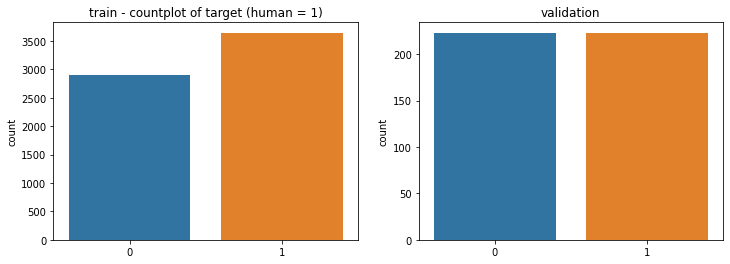

In [14]:
fig, ax =plt.subplots(1,2, figsize=(12,4))
sns.countplot(train_y, ax=ax[0])
sns.countplot(val_y, ax=ax[1])

ax[0].set_title("train - countplot of target (human = 1)")
ax[1].set_title("validation");

#### ImageDataGenerator

In [15]:
def create_IDG(idg_input,train_x):
  datagen = ImageDataGenerator(
                                vertical_flip = idg_input['vertical_flip'],
                                horizontal_flip=idg_input['horizontal_flip'],
                                width_shift_range = idg_input['width_shift_range'],
                                height_shift_range=idg_input['height_shift_range'],
                                fill_mode=idg_input['fill_mode'],
                                brightness_range = idg_input['brightness_range'],
                                preprocessing_function = idg_input['preprocessing_function']
                              )
  #Fitting the Image Generator defined above to the X train data set
  datagen.fit(train_x)

  return datagen

#### model configurations - wandb

In [16]:
def callbacks(model, final_model_path):
     
    mc = tf.keras.callbacks.ModelCheckpoint(final_model_path,
                                            monitor= model_input['model_conf']['monitor'],
                                            verbose= model_input['callback']['model_checkpoint']['verbose'],
                                            save_best_only=True,
                                            save_weights_only=False,
                                            ) 
    earlystop = EarlyStopping(patience= model_input['callback']['early_stop']['patience'], 
                              monitor = model_input['model_conf']['monitor'],
                              verbose = model_input['callback']['early_stop']['verbose'])
    return mc, earlystop

In [17]:
# Model configuration:

wandb.init(project="MAFAT",
           config={
              "batch_size":    model_input['model_conf']["batch_size"],
              "no_epochs":     model_input['model_conf']["no_epochs"],
              "learning_rate": model_input['model_conf']["learning_rate"]
           })

img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
optimizer = Adam(learning_rate = wandb.config.learning_rate)

init = tf.keras.initializers.GlorotNormal(seed = 0)

input_shape = (img_width, img_height, 3)  # must be 3 is RGB for using transfer learning

wandb: Currently logged in as: inbar_sh (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.1
wandb: Run data is saved locally in wandb/run-20200919_110518-g7mtfz3e
wandb: Syncing run clear-snowflake-39


## Models

### Resnet50

In [39]:
# Creating and running the model
# resnet_model = create_model(ResNet50, init, "conv4_block1_2_conv", input_shape)  
# resnet_model.compile(loss=loss_function, optimizer=optimizer, metrics=['AUC', 'accuracy'])
# resnet_model.summary()

In [40]:
# final_model_path = f'{files_path}/{resnet_model.name}.h5'
# mc, earlystop = callbacks(resnet_model, final_model_path)

In [41]:
# datagen = create_IDG(model_input['IDG'],train_x)


# history_resnet50 = resnet_model.fit(datagen.flow(train_x, train_y, batch_size=wandb.config.batch_size),
#                                     steps_per_epoch=len(train_x) // wandb.config.batch_size,
#                                     epochs=wandb.config.no_epochs,
#                                     validation_data=(val_x, val_y),
#                                     validation_steps=len(val_x) // wandb.config.batch_size,
#                                     callbacks=[mc, earlystop, WandbCallback(data_type="image", validation_data=(val_x, val_y))])

### VGG19

In [56]:
# Model configuration:

wandb.init(project="MAFAT",
           config={
              "batch_size":    model_input['model_conf']["batch_size"],
              "no_epochs":     model_input['model_conf']["no_epochs"],
              "learning_rate": model_input['model_conf']["learning_rate"]
           })

img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
optimizer = Adam(learning_rate = wandb.config.learning_rate)

init = tf.keras.initializers.GlorotNormal(seed = 0)

input_shape = (img_width, img_height, 3)  # must be 3 is RGB for using transfer learning

wandb: Waiting for W&B process to finish, PID 9883
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200919_120419-2b7qdx17/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200919_120419-2b7qdx17/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 6
wandb:            loss 0.7952551245689392
wandb:             auc 0.5040794610977173
wandb:        accuracy 0.5571428537368774
wandb:        val_loss 0.7916606664657593
wandb:         val_auc 0.5
wandb:    val_accuracy 0.5
wandb:           _step 16
wandb:        _runtime 638
wandb:      _timestamp 1600517701
wandb:   best_val_loss 0.7916606664657593
wandb:      best_epoch 6
wandb: Run history:
wandb:          epoch ▁▂▂▃▃▄▄▅▅▆▆▇▇█▃▄▄
wandb:           loss █▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁
wandb:            auc ▇█▇▇▆▇▆▆▇▆▆▇▆█▃▁▁
wandb:       accuracy ▇█▇▅▅▆▆▆▅▅▃▆▅█▂▁▁
wandb:       val_loss █▆▆▅▅▅▃▃▃▃▃▃▃▂▂▁▁
wandb:        val_auc ▇██▇██▇▆▇▆███▇▁▁▁
wandb:   val_accuracy ▇▇▇██▂▇▆▇▁▁▄▁▂▁▁▁
w

In [57]:
# Creating and running the model
vgg_19_model = create_model(VGG19, init, "block5_conv2", input_shape)  
vgg_19_model.compile(loss=loss_function, optimizer=optimizer, metrics=['AUC', 'accuracy'])
vgg_19_model.summary()

Model: "transfer_learning_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_15 (Functional)   (None, None, None, 512)   15304768  
_________________________________________________________________
flatten_4 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 7169      
Total params: 15,311,937
Trainable params: 7,169
Non-trainable params: 15,304,768
_________________________________________________________________


In [58]:
final_model_path = f'{files_path}/{vgg_19_model.name}.h5'
mc, earlystop = callbacks(vgg_19_model, final_model_path)

In [59]:
datagen = create_IDG(model_input['IDG'],train_x)

history_vgg19 = vgg_19_model.fit(datagen.flow(train_x, train_y, batch_size=wandb.config.batch_size),
          steps_per_epoch=len(train_x) // wandb.config.batch_size,
          epochs=wandb.config.no_epochs,
          validation_data=(val_x, val_y),
          validation_steps=len(val_x) // wandb.config.batch_size,
          callbacks=[mc, earlystop, WandbCallback(data_type="image", validation_data=(val_x, val_y))])
          

Epoch 1/50
204/204 [==============================] - ETA: 0s - loss: 5.6022 - auc: 0.8777 - accuracy: 0.8687
Epoch 00001: val_accuracy improved from -inf to 0.68610, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/transfer_learning_model.h5
204/204 [==============================] - 8s 39ms/step - loss: 5.6022 - auc: 0.8777 - accuracy: 0.8687 - val_loss: 0.6237 - val_auc: 0.8320 - val_accuracy: 0.6861
Epoch 2/50
204/204 [==============================] - ETA: 0s - loss: 4.4321 - auc: 0.8997 - accuracy: 0.8929
Epoch 00002: val_accuracy improved from 0.68610 to 0.75785, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/transfer_learning_model.h5
204/204 [==============================] - 7s 37ms/step - loss: 4.4321 - auc: 0.8997 - accuracy: 0.8929 - val_loss: 0.6223 - val_auc: 0.8793 - val_accuracy: 0.7578
Epoch 3/50
204/204 [==============================] - ETA: 0s - loss: 3.2055 - auc: 0.9189 

In [60]:
vgg_19_model.layers[0].trainable = True

optimizer_v2 = Adam(learning_rate = wandb.config.learning_rate / 10)

vgg_19_model.compile(loss=loss_function, optimizer=optimizer_v2, metrics=['AUC', 'accuracy'])
vgg_19_model.summary()

Model: "transfer_learning_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_15 (Functional)   (None, None, None, 512)   15304768  
_________________________________________________________________
flatten_4 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 7169      
Total params: 15,311,937
Trainable params: 15,311,937
Non-trainable params: 0
_________________________________________________________________


In [61]:
history_vgg19 = vgg_19_model.fit(datagen.flow(train_x, train_y, batch_size=wandb.config.batch_size),
          steps_per_epoch=len(train_x) // wandb.config.batch_size,
          epochs=wandb.config.no_epochs,
          initial_epoch = 10,
          validation_data=(val_x, val_y),
          validation_steps=len(val_x) // wandb.config.batch_size,
          callbacks=[mc, earlystop, WandbCallback(data_type="image", validation_data=(val_x, val_y))])

Epoch 11/50
204/204 [==============================] - ETA: 0s - loss: 4.1985 - auc: 0.9080 - accuracy: 0.8716
Epoch 00011: val_accuracy did not improve from 0.79596
204/204 [==============================] - 21s 104ms/step - loss: 4.1985 - auc: 0.9080 - accuracy: 0.8716 - val_loss: 0.6139 - val_auc: 0.8994 - val_accuracy: 0.5135
Epoch 12/50
204/204 [==============================] - ETA: 0s - loss: 0.2201 - auc: 0.9701 - accuracy: 0.9127
Epoch 00012: val_accuracy did not improve from 0.79596
204/204 [==============================] - 20s 100ms/step - loss: 0.2201 - auc: 0.9701 - accuracy: 0.9127 - val_loss: 0.6166 - val_auc: 0.8922 - val_accuracy: 0.5045
Epoch 13/50
204/204 [==============================] - ETA: 0s - loss: 0.1791 - auc: 0.9798 - accuracy: 0.9309
Epoch 00013: val_accuracy did not improve from 0.79596
204/204 [==============================] - 20s 99ms/step - loss: 0.1791 - auc: 0.9798 - accuracy: 0.9309 - val_loss: 0.6164 - val_auc: 0.8979 - val_accuracy: 0.5224
Epoch

KeyboardInterrupt: ignored

## **Results**

In [ ]:
# plot_loss_and_accuracy_over_epoches(history_resnet50)

In [ ]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
# pred = [resnet_model.predict(train_x), resnet_model.predict(val_x)]
# actual = [train_y, val_y]
# stats(pred, actual)

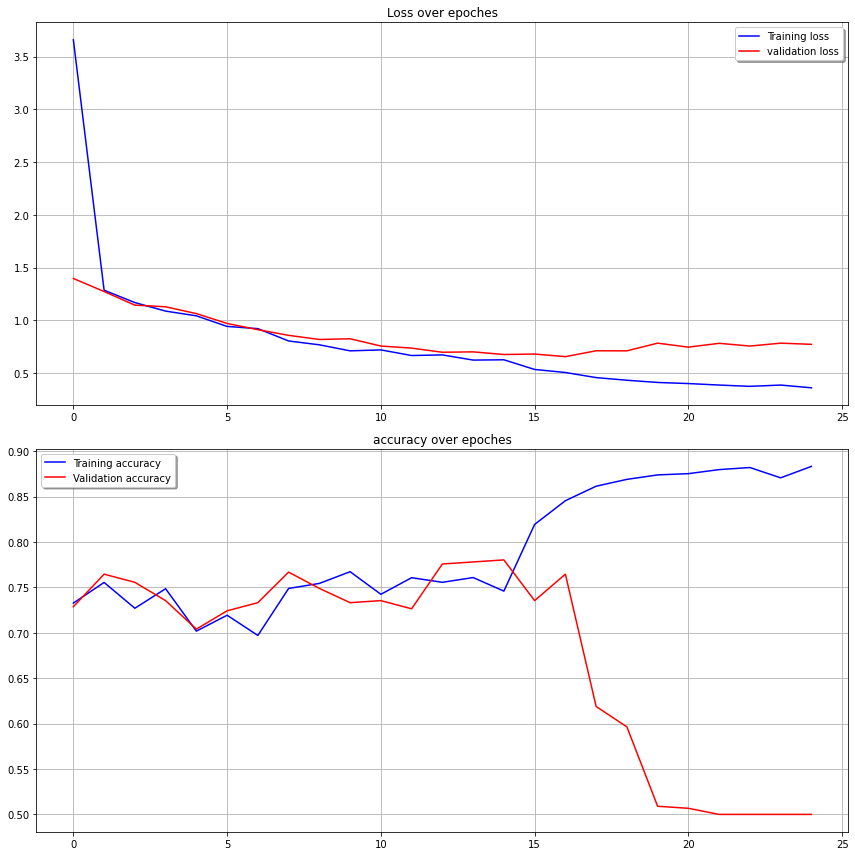

In [47]:
plot_loss_and_accuracy_over_epoches(history_vgg19)

load the final model (the best model from the training phase)

In [35]:
final_model = tf.keras.models.load_model(final_model_path)

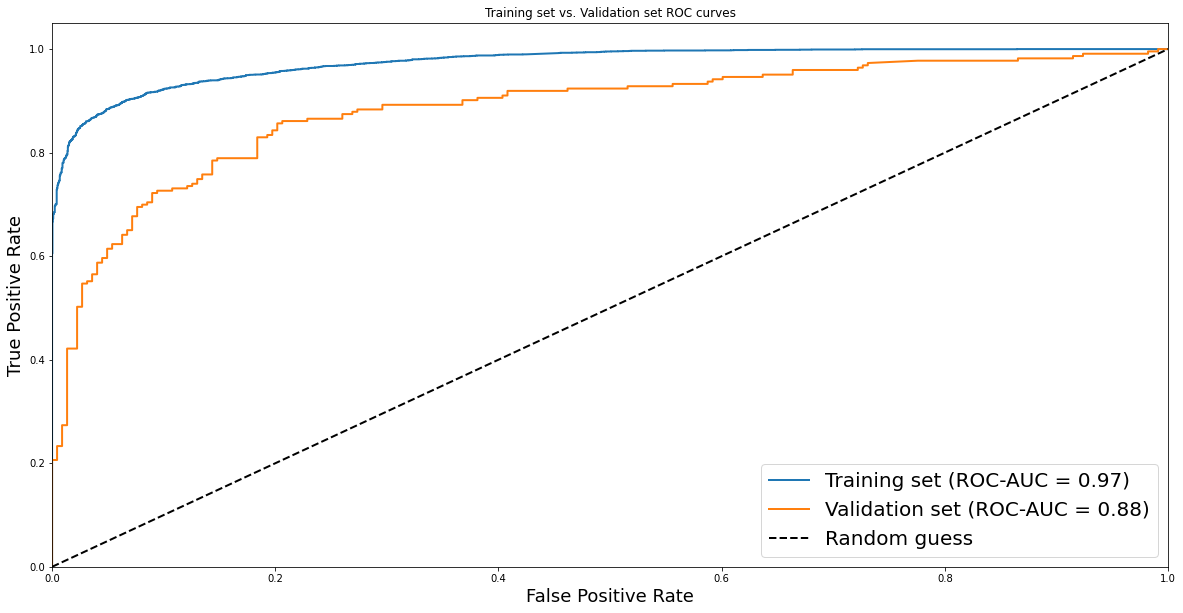

In [36]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [final_model.predict(train_x), final_model.predict(val_x)]
actual = [train_y, val_y]
stats(pred, actual)

In [ ]:
# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = final_model.predict(test_x)
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)

In [ ]:
# Download zip file
from zipfile import ZipFile
from google.colab import files

with ZipFile('submission.zip', 'w') as myzip:
  myzip.write('submission.csv')

files.download('submission.zip')